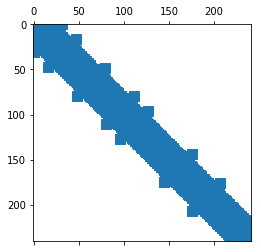

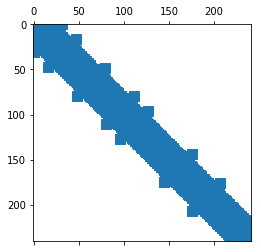

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [2]:
import scipy.sparse
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import pylab as pl
import scipy as sp
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import healpy as hp

bw = 8
npix = 2*bw*(2*bw-1)+1
L = scipy.sparse.load_npz('../../../equiangular/normal/matrices/stiffness_matrix_{}.npz'.format(bw))
B = scipy.sparse.load_npz('../../../equiangular/normal/matrices/mass_matrix_{}.npz'.format(bw))
reordering_mask = np.load("../../../equiangular/normal/15_reordering_masks/reordering_mask_{}.npy".format(bw))
L = L[reordering_mask]
B = B[reordering_mask]
L = L[:,reordering_mask]
B = B[:,reordering_mask]

plt.spy(L)
plt.show()
plt.spy(B)
plt.show()

B_inv = scipy.sparse.linalg.inv(B)
signal = np.zeros(npix)
signal[0] = 1

In [3]:
def subplotsphere(fig, signal, coords, tri, j):
    ax = fig.add_subplot(2,2,j+1, projection='3d')
    M = np.max(signal)
    for simplex in tri.simplices:
        triangle = a3.art3d.Poly3DCollection([coords[simplex]])
        triangle.set_color(colors.rgb2hex([np.max(signal[simplex])/M, 0,0]))
        triangle.set_edgecolor('k')
        ax.add_collection3d(triangle)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

# FEM diffusion


In [4]:
B_lumped_inverse = np.diag(1./np.asarray(np.sum(B.todense(), axis=1))[:,0])
B12_lumped_inverse = np.diag(1./np.sqrt(np.asarray(np.sum(B.todense(), axis=1))[:,0]))
BinvL_lumped = B_lumped_inverse@L
BinvL_lumped = scipy.sparse.csc_matrix(BinvL_lumped)
BinvL = B_inv@L
B12LB12_lumped = scipy.sparse.csc_matrix(B12_lumped_inverse@L@B12_lumped_inverse)

M1 = scipy.linalg.expm(-0.1*B12LB12_lumped)
M2 = scipy.linalg.expm(-0.1*BinvL_lumped)
M3 = scipy.linalg.expm(-0.1*BinvL)

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


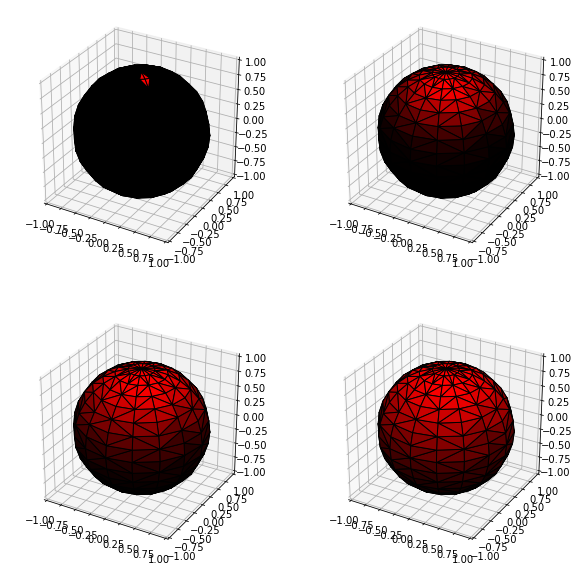

In [6]:
def diffuse_symmetric_lumped(x):
    return M1@x

def diffuse_lumped(x):
    return M2@x

def diffuse(x):
    return M3@x

def create_coords(bw):
    alpha = np.arange(2 * bw) * np.pi / bw
    beta = np.arange(2 * bw) * np.pi / (2. * bw)
    theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
    ct = np.cos(theta).flatten()
    st = np.sin(theta).flatten()
    cp = np.cos(phi).flatten()
    sp = np.sin(phi).flatten()
    x = st * cp
    y = st * sp
    z = ct
    coords = np.vstack([x, y, z]).T
    coords = np.asarray(coords, dtype=np.float32)
    coords = coords[2*bw-1:]
    return coords

fig = plt.figure(figsize=(10,10))

signal = np.zeros(npix)
signal[15] = 1
indexes = range(npix)
coords = create_coords(bw)

tri = ConvexHull(coords)  # just for plotting

for j in range(4):
    subplotsphere(fig, signal, coords, tri, j)
    
    # diffusing 3 times
    for i in range(1):
        signal = abs(diffuse(signal))
        
plt.savefig('img/FEM_diffusion')

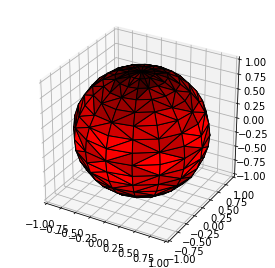

In [7]:
fig = plt.figure(figsize=(10,10))
subplotsphere(fig, np.asarray(np.sum(B.todense(), axis=1))[:,0], coords, tri, j)

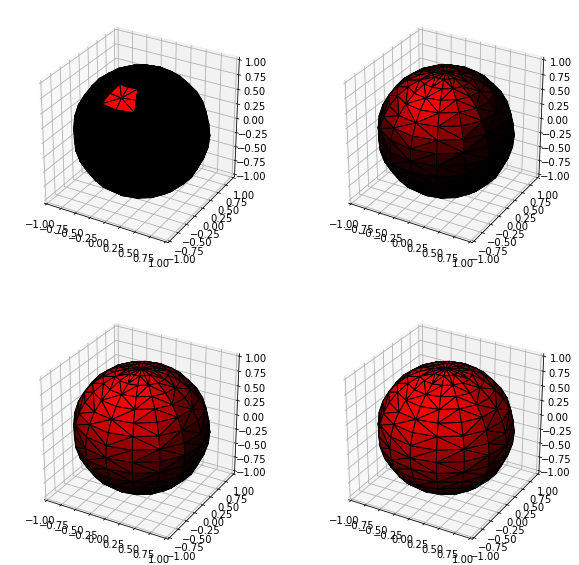

In [10]:
fig = plt.figure(figsize=(10,10))
signal = np.zeros(npix)
signal[45] = 1

for j in range(4):
    subplotsphere(fig, signal, coords, tri, j)
    
    # diffusing 3 times
    for i in range(1):
        signal = abs(diffuse_lumped(signal))
plt.savefig('img/FEM_lumped_diffusion')

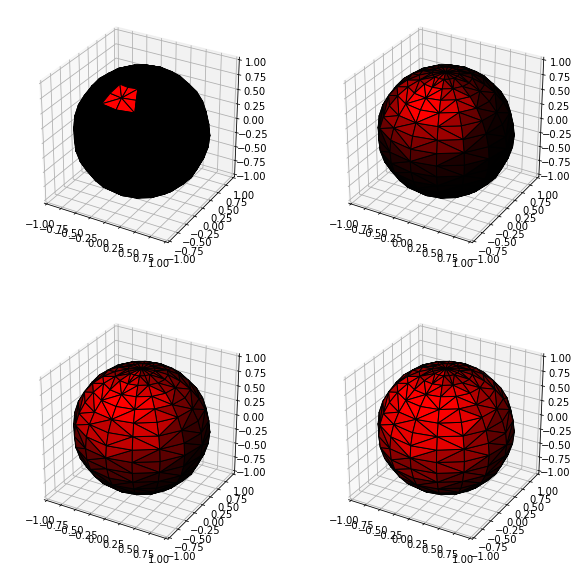

In [11]:
fig = plt.figure(figsize=(10,10))
signal = np.zeros(npix)
signal[45] = 1

for j in range(4):
    subplotsphere(fig, signal, coords, tri, j)
    
    # diffusing 3 times
    for i in range(1):
        signal = abs(diffuse_symmetric_lumped(signal))
plt.savefig('img/FEM_lumped_symmetric_diffusion')

# GRAPH diffusion

2019-06-12 18:53:03,805:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


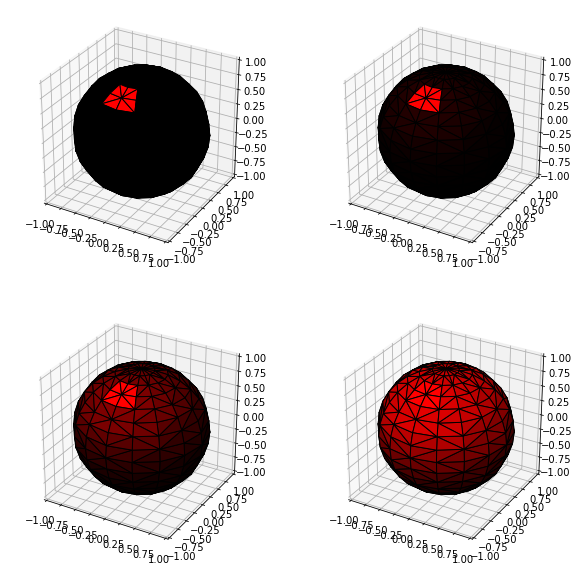

In [13]:
from pygsp import filters
from deepsphere import utils

# re initializing the signal to diffuse
signal = np.zeros(npix)
signal[45] = 1

fig = plt.figure(figsize=(10,10))
# building the graph and the heat kernel
from pygsp.graphs import Graph

class FullSphereEquiangular(Graph):
    """Modified from the class implemented by Droxef
    https://github.com/Droxef/PDMdeepsphere/
    """
    sigmas = {4:0.5,
              8:0.3,
              16: 0.1, 
              32: 0.03,
              64: 0.01}
    
    def __init__(self, bw=64):
       
        self.bw = bw
        coords = create_coords(bw)
        
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        W = np.exp(-distances_squared/self.sigmas[bw])
        W = W-np.diag(np.diag(W))
        super(FullSphereEquiangular, self).__init__(W=W, coords=coords)
        

graph = FullSphereEquiangular(bw)


heat_kernel = filters.Heat(graph, scale=1)

for j in range(4):
    subplotsphere(fig, signal, coords, tri, j)
    
    # diffusing 3 times
    for i in range(3):
        signal = heat_kernel.filter(signal)

plt.savefig('img/GRAPH_diffusion')